# Imports and API

In [159]:
import sys
import os
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import wandb

sys.path.append("../../")

# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    palette="deep",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)


# Weights & Biases

api = wandb.Api()


def get_run_results(
    entity: str,
    project: str,
    metrics: list[str],
    filters: dict[str, Any],
    x_axis: str = "epoch",
    user: str | None = None,
    save_path: str | None = None,
) -> pd.DataFrame:
    """Pulls data from the W&B API and returns a dataframe with either the best epoch performance for each run
    (when `best_epoch=True`) or the entire training trajectory across runs (when `best_epoch=False`).

    Args:
        entity (str): W&B entity.
        dataset (str): The W&B project.
        metrics (list[str]): Logged metrics we want to keep.
        filters (dict[str, Any]): W&B API filters used to select only a subset of runs. See code below for examples.
        x_axis (str): The x-axis to plot the metrics against.
        save_path (str, optional): Optionally save the resulting dataframe. Note that if the file already exists, we retrieve its data and return that rather than querying the API. Defaults to `None`.

    Returns:
        pd.DataFrame: Dataframe of results. It contains the run id, epoch, config arguments, and `metrics`.
    """
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        print(f"Loading from cached file {save_path}...")
        data = pd.read_csv(save_path)
        return data

    # Fetch all run data from the API
    runs = api.runs(f"{entity}/{project}", filters=filters)
    if user is not None:
        runs = [run for run in runs if run.user.username == user]

    # Collect all of the run histories into a dataframe
    data = []
    for run in runs:
        run_data = run.history(samples=1000000, x_axis=x_axis, keys=metrics)
        # run_data = run.history(samples=1000000, x_axis="epoch", keys=metrics)
        run_data = run_data.assign(run_id=run.id, **run.config)
        data.append(run_data)
    data = pd.concat(data)

    # Re-order columns
    data = data[["run_id", x_axis] + metrics + list(run.config.keys())]

    # Cache data
    if save_path is not None:
        data.to_csv(save_path, index=False)

    return data

# Simple tasks

In [146]:
data = get_run_results(
    entity="dhanya-shridar",
    project="Prequential-ICL",
    metrics=["val_tasks/n_sample_loss_train", "val_tasks/n_sample_loss_nexttoken"],
    x_axis="n_samples",
    filters={
        "tags": {
            "$in": [
                "experiments/sgd_vs_prequential/regression",
                "experiments/prequential_vs_train/regression",
            ]
        },
    },
    user="ericelmoznino",
    save_path="data/simple_tasks.csv",
)
data["meta_objective"] = data["meta_objective"].fillna("sgd")
data["dataset"] = (
    data["name"].str.replace("meta_optimizer_", "").str.replace("sgd_optimizer_", "")
)

# For plotting
metric_map = {
    "nexttoken": "Prequential curve\n(next-token error)",
    "train": "Train risk curve\n(past-token error)",
}
dataset_map = {
    "linear_regression": "Linear regression",
    "sinusoid_regression": "Sinusoid regression",
}

### Prequential vs. Train risk

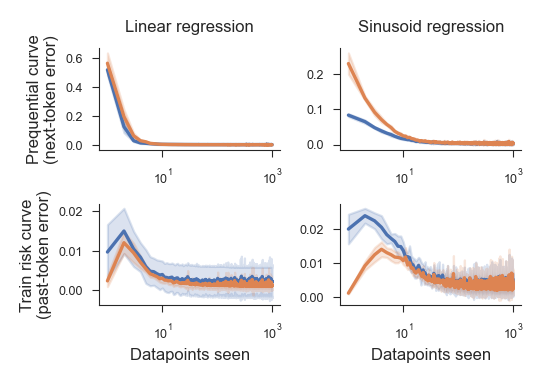

In [147]:
fig, axs = plt.subplots(2, 2, figsize=(2.6, 1.8))

d = data[data["meta_objective"].isin(["prequential", "train"])]

for i, metric in enumerate(["nexttoken", "train"]):
    for j, dataset in enumerate(["linear_regression", "sinusoid_regression"]):
        sns.lineplot(
            data=d[d["dataset"] == dataset],
            x="n_samples",
            y=f"val_tasks/n_sample_loss_{metric}",
            hue="meta_objective",
            hue_order=["prequential", "train"],
            palette=[sns.color_palette()[0], sns.color_palette()[1]],
            errorbar="sd",
            ax=axs[i, j],
        )
        axs[i, j].set(
            xscale="log",
            xlabel="Datapoints seen" if i == 1 else None,
            ylabel=metric_map[metric] if j == 0 else None,
            title=dataset_map[dataset] if i == 0 else None,
        )
        axs[i, j].legend().remove()

fig.savefig("saved/simple_tasks_prequential_vs_train_risk.pdf")
plt.show()

### Prequential vs. SGD

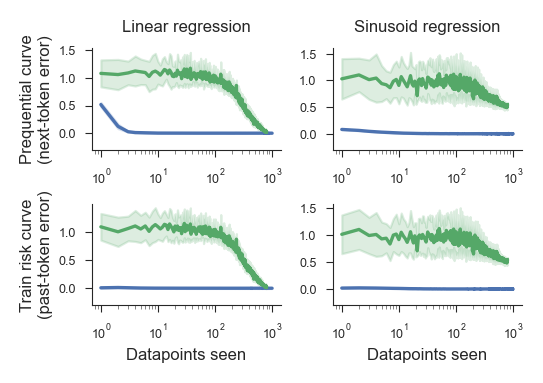

In [204]:
fig, axs = plt.subplots(2, 2, figsize=(2.6, 1.8))

d = data[data["meta_objective"].isin(["prequential", "sgd"])]


def smooth(x, smoothing_columns, sigma=1.0):
    x.loc[:, smoothing_columns] = gaussian_filter1d(x[smoothing_columns], sigma, axis=0)
    return x


d = d.sort_values(["run_id", "n_samples"])
d[d["meta_objective"] == "sgd"] = (
    d[d["meta_objective"] == "sgd"]
    .groupby("run_id")
    .apply(
        lambda x: smooth(
            x,
            ["val_tasks/n_sample_loss_nexttoken", "val_tasks/n_sample_loss_train"],
            sigma=50.0,
        ),
        include_groups=False,
    )
    .reset_index(level="run_id")
)

for i, metric in enumerate(["nexttoken", "train"]):
    for j, dataset in enumerate(["linear_regression", "sinusoid_regression"]):
        sns.lineplot(
            data=d[d["dataset"] == dataset],
            x="n_samples",
            y=f"val_tasks/n_sample_loss_{metric}",
            hue="meta_objective",
            hue_order=["prequential", "sgd"],
            palette=[sns.color_palette()[0], sns.color_palette()[2]],
            errorbar="sd",
            ax=axs[i, j],
        )
        axs[i, j].set(
            xscale="log",
            xlabel="Datapoints seen" if i == 1 else None,
            ylabel=metric_map[metric] if j == 0 else None,
            title=dataset_map[dataset] if i == 0 else None,
            ylim=(-0.3, None),
        )
        axs[i, j].legend().remove()

fig.savefig("saved/simple_tasks_prequential_vs_sgd.pdf")
plt.show()